# Fine-tuning LSTM model using PSO optimization method

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pyswarms.single.global_best import GlobalBestPSO
tf.random.set_seed(33)

In [154]:
data_dir= 'Data/Stock_Values'
files_names= os.listdir(path= data_dir)[:10]

dataset =[]
for files_name in files_names:
    file_path= os.path.join(data_dir, files_name)
    data = pd.read_csv(file_path)
    data = pd.DataFrame(data['Close']).values.astype('float32')
    if len(data)>=503: 
        # normalize the dataset with MinMax normalization
        scaler = MinMaxScaler(feature_range=(0, 1))
        data = scaler.fit_transform(data)
        dataset.append(data)
dataset= np.array(dataset).reshape(-1,1)

In [155]:
# split into train and test sets
train_size = int(len(dataset) * 0.95)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

4778 252


In [156]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    dataX.append(dataset[i:(i+look_back), 0])
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [157]:
# Define the objective function
def objective_function(params):
    
    Costs = np.zeros(params.shape[0])  
    for i in range(params.shape[0]):
        look_back= int(params[i, 0])
        Nunits= int(params[i, 1])
        activation= int(params[i, 2])
        NLayer= int(params[i, 2])
        
        if activation < 2:
            activation = 'tanh'
        else: 
            activation = 'relu'
    
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # create and fit the LSTM network
    model = Sequential()
    for t in range(1,NLayer+1):
        if t == 1 and NLayer == 1:
            model.add(LSTM(units=Nunits, activation=activation, input_shape=(1, look_back)))
        elif t == 1 and NLayer > 1:
            model.add(LSTM(units=Nunits, activation=activation, input_shape=(1, look_back), return_sequences=True))
        elif t == NLayer:
            model.add(LSTM(units=Nunits, activation=activation))
        else:
            model.add(LSTM(units=Nunits, activation=activation, return_sequences=True)) 
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
    
    
    # make predictions
    trainPredict = model.predict(trainX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    # calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    
    
    # make predictions
    testPredict = model.predict(testX)
    # invert predictions
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    
    Cost= (0.1*trainScore + 0.9*testScore)**2
    
    # Return the validation loss as the objective value
    return Cost

In [158]:
# Define hyperparameters 
#  [look_back, Nunits, activation, NLayer]
# Define the bounds for the hyperparameters
lower_bound = np.array([2, 4, 1, 1])
upper_bound = np.array([30, 20, 3, 5])
bounds = (lower_bound, upper_bound)

In [159]:
# Initialize the optimizer
options={'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles= 15, dimensions= 4, options=options, bounds=bounds)

# Run the optimization
best_costs, best_hyperparams = optimizer.optimize(objective_function, iters= 20)

# Print the best hyperparameters found
print("Best position:", best_hyperparams)
print("Best cost:", best_costs)

2024-04-12 13:51:22,421 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/20

Epoch 1/10
4750/4750 - 10s - loss: 0.0040 - 10s/epoch - 2ms/step
Epoch 2/10
4750/4750 - 6s - loss: 0.0022 - 6s/epoch - 1ms/step
Epoch 3/10
4750/4750 - 9s - loss: 0.0020 - 9s/epoch - 2ms/step
Epoch 4/10
4750/4750 - 6s - loss: 0.0019 - 6s/epoch - 1ms/step
Epoch 5/10
4750/4750 - 9s - loss: 0.0018 - 9s/epoch - 2ms/step
Epoch 6/10
4750/4750 - 5s - loss: 0.0017 - 5s/epoch - 1ms/step
Epoch 7/10
4750/4750 - 10s - loss: 0.0017 - 10s/epoch - 2ms/step
Epoch 8/10
4750/4750 - 6s - loss: 0.0016 - 6s/epoch - 1ms/step
Epoch 9/10
4750/4750 - 10s - loss: 0.0016 - 10s/epoch - 2ms/step
Epoch 10/10
4750/4750 - 6s - loss: 0.0016 - 6s/epoch - 1ms/step
149/149 [==============================] - 1s 1ms/step
Train Score: 1.52 RMSE
7/7 [==============================] - 0s 2ms/step


pyswarms.single.global_best:   5%|▌         |1/20, best_cost=1.77

Test Score: 1.31 RMSE
Epoch 1/10
4755/4755 - 13s - loss: 0.0098 - 13s/epoch - 3ms/step
Epoch 2/10
4755/4755 - 8s - loss: 0.0023 - 8s/epoch - 2ms/step
Epoch 3/10
4755/4755 - 9s - loss: 0.0020 - 9s/epoch - 2ms/step
Epoch 4/10
4755/4755 - 10s - loss: 0.0018 - 10s/epoch - 2ms/step
Epoch 5/10
4755/4755 - 9s - loss: 0.0018 - 9s/epoch - 2ms/step
Epoch 6/10
4755/4755 - 12s - loss: 0.0018 - 12s/epoch - 3ms/step
Epoch 7/10
4755/4755 - 7s - loss: 0.0017 - 7s/epoch - 2ms/step
Epoch 8/10
4755/4755 - 10s - loss: 0.0017 - 10s/epoch - 2ms/step
Epoch 9/10
4755/4755 - 9s - loss: 0.0017 - 9s/epoch - 2ms/step
Epoch 10/10
4755/4755 - 9s - loss: 0.0017 - 9s/epoch - 2ms/step
149/149 [==============================] - 0s 1ms/step
Train Score: 1.31 RMSE
8/8 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  10%|█         |2/20, best_cost=1.11

Test Score: 1.03 RMSE
Epoch 1/10
4760/4760 - 11s - loss: 0.0041 - 11s/epoch - 2ms/step
Epoch 2/10
4760/4760 - 7s - loss: 0.0021 - 7s/epoch - 1ms/step
Epoch 3/10
4760/4760 - 10s - loss: 0.0019 - 10s/epoch - 2ms/step
Epoch 4/10
4760/4760 - 7s - loss: 0.0018 - 7s/epoch - 1ms/step
Epoch 5/10
4760/4760 - 9s - loss: 0.0017 - 9s/epoch - 2ms/step
Epoch 6/10
4760/4760 - 7s - loss: 0.0017 - 7s/epoch - 1ms/step
Epoch 7/10
4760/4760 - 10s - loss: 0.0016 - 10s/epoch - 2ms/step
Epoch 8/10
4760/4760 - 7s - loss: 0.0016 - 7s/epoch - 1ms/step
Epoch 9/10
4760/4760 - 10s - loss: 0.0016 - 10s/epoch - 2ms/step
Epoch 10/10
4760/4760 - 7s - loss: 0.0015 - 7s/epoch - 1ms/step
149/149 [==============================] - 1s 1ms/step
Train Score: 1.29 RMSE
8/8 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  15%|█▌        |3/20, best_cost=0.864

Test Score: 0.89 RMSE
Epoch 1/10
4765/4765 - 11s - loss: 0.0080 - 11s/epoch - 2ms/step
Epoch 2/10
4765/4765 - 11s - loss: 0.0020 - 11s/epoch - 2ms/step
Epoch 3/10
4765/4765 - 7s - loss: 0.0018 - 7s/epoch - 1ms/step
Epoch 4/10
4765/4765 - 10s - loss: 0.0018 - 10s/epoch - 2ms/step
Epoch 5/10
4765/4765 - 7s - loss: 0.0017 - 7s/epoch - 2ms/step
Epoch 6/10
4765/4765 - 10s - loss: 0.0017 - 10s/epoch - 2ms/step
Epoch 7/10
4765/4765 - 8s - loss: 0.0017 - 8s/epoch - 2ms/step
Epoch 8/10
4765/4765 - 9s - loss: 0.0016 - 9s/epoch - 2ms/step
Epoch 9/10
4765/4765 - 9s - loss: 0.0016 - 9s/epoch - 2ms/step
Epoch 10/10
4765/4765 - 9s - loss: 0.0016 - 9s/epoch - 2ms/step
149/149 [==============================] - 0s 1ms/step
Train Score: 1.34 RMSE
8/8 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  20%|██        |4/20, best_cost=0.864

Test Score: 0.89 RMSE
Epoch 1/10
4768/4768 - 11s - loss: 0.0043 - 11s/epoch - 2ms/step
Epoch 2/10
4768/4768 - 6s - loss: 0.0018 - 6s/epoch - 1ms/step
Epoch 3/10
4768/4768 - 10s - loss: 0.0017 - 10s/epoch - 2ms/step
Epoch 4/10
4768/4768 - 6s - loss: 0.0016 - 6s/epoch - 1ms/step
Epoch 5/10
4768/4768 - 10s - loss: 0.0016 - 10s/epoch - 2ms/step
Epoch 6/10
4768/4768 - 6s - loss: 0.0015 - 6s/epoch - 1ms/step
Epoch 7/10
4768/4768 - 10s - loss: 0.0015 - 10s/epoch - 2ms/step
Epoch 8/10
4768/4768 - 6s - loss: 0.0015 - 6s/epoch - 1ms/step
Epoch 9/10
4768/4768 - 10s - loss: 0.0015 - 10s/epoch - 2ms/step
Epoch 10/10
4768/4768 - 6s - loss: 0.0015 - 6s/epoch - 1ms/step
149/149 [==============================] - 1s 2ms/step
Train Score: 1.45 RMSE
8/8 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  25%|██▌       |5/20, best_cost=0.864

Test Score: 1.33 RMSE
Epoch 1/10
4770/4770 - 11s - loss: 0.0045 - 11s/epoch - 2ms/step
Epoch 2/10
4770/4770 - 9s - loss: 0.0019 - 9s/epoch - 2ms/step
Epoch 3/10
4770/4770 - 8s - loss: 0.0017 - 8s/epoch - 2ms/step
Epoch 4/10
4770/4770 - 10s - loss: 0.0016 - 10s/epoch - 2ms/step
Epoch 5/10
4770/4770 - 6s - loss: 0.0015 - 6s/epoch - 1ms/step
Epoch 6/10
4770/4770 - 9s - loss: 0.0015 - 9s/epoch - 2ms/step
Epoch 7/10
4770/4770 - 6s - loss: 0.0015 - 6s/epoch - 1ms/step
Epoch 8/10
4770/4770 - 9s - loss: 0.0015 - 9s/epoch - 2ms/step
Epoch 9/10
4770/4770 - 7s - loss: 0.0015 - 7s/epoch - 1ms/step
Epoch 10/10
4770/4770 - 8s - loss: 0.0014 - 8s/epoch - 2ms/step
150/150 [==============================] - 1s 3ms/step
Train Score: 1.28 RMSE
8/8 [==============================] - 0s 3ms/step


pyswarms.single.global_best:  30%|███       |6/20, best_cost=0.864

Test Score: 0.92 RMSE
Epoch 1/10
4770/4770 - 12s - loss: 0.0082 - 12s/epoch - 2ms/step
Epoch 2/10
4770/4770 - 9s - loss: 0.0022 - 9s/epoch - 2ms/step
Epoch 3/10
4770/4770 - 9s - loss: 0.0018 - 9s/epoch - 2ms/step
Epoch 4/10
4770/4770 - 8s - loss: 0.0017 - 8s/epoch - 2ms/step
Epoch 5/10
4770/4770 - 11s - loss: 0.0017 - 11s/epoch - 2ms/step
Epoch 6/10
4770/4770 - 8s - loss: 0.0017 - 8s/epoch - 2ms/step
Epoch 7/10
4770/4770 - 11s - loss: 0.0016 - 11s/epoch - 2ms/step
Epoch 8/10
4770/4770 - 8s - loss: 0.0016 - 8s/epoch - 2ms/step
Epoch 9/10
4770/4770 - 10s - loss: 0.0016 - 10s/epoch - 2ms/step
Epoch 10/10
4770/4770 - 9s - loss: 0.0016 - 9s/epoch - 2ms/step
150/150 [==============================] - 1s 3ms/step
Train Score: 1.31 RMSE
8/8 [==============================] - 0s 3ms/step


pyswarms.single.global_best:  35%|███▌      |7/20, best_cost=0.864

Test Score: 1.00 RMSE
Epoch 1/10
4770/4770 - 9s - loss: 0.0074 - 9s/epoch - 2ms/step
Epoch 2/10
4770/4770 - 10s - loss: 0.0018 - 10s/epoch - 2ms/step
Epoch 3/10
4770/4770 - 7s - loss: 0.0018 - 7s/epoch - 2ms/step
Epoch 4/10
4770/4770 - 9s - loss: 0.0016 - 9s/epoch - 2ms/step
Epoch 5/10
4770/4770 - 8s - loss: 0.0016 - 8s/epoch - 2ms/step
Epoch 6/10
4770/4770 - 9s - loss: 0.0016 - 9s/epoch - 2ms/step
Epoch 7/10
4770/4770 - 8s - loss: 0.0016 - 8s/epoch - 2ms/step
Epoch 8/10
4770/4770 - 8s - loss: 0.0016 - 8s/epoch - 2ms/step
Epoch 9/10
4770/4770 - 9s - loss: 0.0016 - 9s/epoch - 2ms/step
Epoch 10/10
4770/4770 - 8s - loss: 0.0015 - 8s/epoch - 2ms/step
150/150 [==============================] - 1s 2ms/step
Train Score: 1.30 RMSE
8/8 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  40%|████      |8/20, best_cost=0.864

Test Score: 1.03 RMSE
Epoch 1/10
4767/4767 - 12s - loss: 0.0043 - 12s/epoch - 2ms/step
Epoch 2/10
4767/4767 - 6s - loss: 0.0018 - 6s/epoch - 1ms/step
Epoch 3/10
4767/4767 - 9s - loss: 0.0016 - 9s/epoch - 2ms/step
Epoch 4/10
4767/4767 - 6s - loss: 0.0016 - 6s/epoch - 1ms/step
Epoch 5/10
4767/4767 - 10s - loss: 0.0016 - 10s/epoch - 2ms/step
Epoch 6/10
4767/4767 - 6s - loss: 0.0016 - 6s/epoch - 1ms/step
Epoch 7/10
4767/4767 - 9s - loss: 0.0015 - 9s/epoch - 2ms/step
Epoch 8/10
4767/4767 - 5s - loss: 0.0015 - 5s/epoch - 1ms/step
Epoch 9/10
4767/4767 - 10s - loss: 0.0015 - 10s/epoch - 2ms/step
Epoch 10/10
4767/4767 - 6s - loss: 0.0015 - 6s/epoch - 1ms/step
149/149 [==============================] - 1s 1ms/step
Train Score: 1.27 RMSE
8/8 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  45%|████▌     |9/20, best_cost=0.722

Test Score: 0.80 RMSE
Epoch 1/10
4765/4765 - 11s - loss: 0.0054 - 11s/epoch - 2ms/step
Epoch 2/10
4765/4765 - 7s - loss: 0.0023 - 7s/epoch - 2ms/step
Epoch 3/10
4765/4765 - 10s - loss: 0.0021 - 10s/epoch - 2ms/step
Epoch 4/10
4765/4765 - 8s - loss: 0.0019 - 8s/epoch - 2ms/step
Epoch 5/10
4765/4765 - 9s - loss: 0.0018 - 9s/epoch - 2ms/step
Epoch 6/10
4765/4765 - 9s - loss: 0.0017 - 9s/epoch - 2ms/step
Epoch 7/10
4765/4765 - 9s - loss: 0.0018 - 9s/epoch - 2ms/step
Epoch 8/10
4765/4765 - 10s - loss: 0.0017 - 10s/epoch - 2ms/step
Epoch 9/10
4765/4765 - 7s - loss: 0.0016 - 7s/epoch - 1ms/step
Epoch 10/10
4765/4765 - 11s - loss: 0.0016 - 11s/epoch - 2ms/step
149/149 [==============================] - 0s 1ms/step
Train Score: 1.37 RMSE
8/8 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  50%|█████     |10/20, best_cost=0.722

Test Score: 0.91 RMSE
Epoch 1/10
4763/4763 - 12s - loss: 0.0071 - 12s/epoch - 2ms/step
Epoch 2/10
4763/4763 - 7s - loss: 0.0022 - 7s/epoch - 2ms/step
Epoch 3/10
4763/4763 - 11s - loss: 0.0020 - 11s/epoch - 2ms/step
Epoch 4/10
4763/4763 - 8s - loss: 0.0018 - 8s/epoch - 2ms/step
Epoch 5/10
4763/4763 - 11s - loss: 0.0017 - 11s/epoch - 2ms/step
Epoch 6/10
4763/4763 - 8s - loss: 0.0018 - 8s/epoch - 2ms/step
Epoch 7/10
4763/4763 - 10s - loss: 0.0017 - 10s/epoch - 2ms/step
Epoch 8/10
4763/4763 - 10s - loss: 0.0016 - 10s/epoch - 2ms/step
Epoch 9/10
4763/4763 - 9s - loss: 0.0017 - 9s/epoch - 2ms/step
Epoch 10/10
4763/4763 - 11s - loss: 0.0016 - 11s/epoch - 2ms/step
149/149 [==============================] - 0s 1ms/step
Train Score: 1.33 RMSE
8/8 [==============================] - 0s 2ms/step



pyswarms.single.global_best:  50%|█████     |10/20, best_cost=0.722

Test Score: 0.89 RMSE



pyswarms.single.global_best:  55%|█████▌    |11/20, best_cost=0.722

Epoch 1/10
4763/4763 - 9s - loss: 0.0044 - 9s/epoch - 2ms/step
Epoch 2/10
4763/4763 - 8s - loss: 0.0019 - 8s/epoch - 2ms/step
Epoch 3/10
4763/4763 - 7s - loss: 0.0018 - 7s/epoch - 2ms/step
Epoch 4/10
4763/4763 - 8s - loss: 0.0017 - 8s/epoch - 2ms/step
Epoch 5/10
4763/4763 - 7s - loss: 0.0016 - 7s/epoch - 1ms/step
Epoch 6/10
4763/4763 - 9s - loss: 0.0017 - 9s/epoch - 2ms/step
Epoch 7/10
4763/4763 - 7s - loss: 0.0016 - 7s/epoch - 1ms/step
Epoch 8/10
4763/4763 - 9s - loss: 0.0015 - 9s/epoch - 2ms/step
Epoch 9/10
4763/4763 - 7s - loss: 0.0016 - 7s/epoch - 1ms/step
Epoch 10/10
4763/4763 - 8s - loss: 0.0015 - 8s/epoch - 2ms/step
149/149 [==============================] - 0s 1ms/step
Train Score: 1.32 RMSE
8/8 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  60%|██████    |12/20, best_cost=0.722

Test Score: 0.87 RMSE
Epoch 1/10
4763/4763 - 12s - loss: 0.0082 - 12s/epoch - 3ms/step
Epoch 2/10
4763/4763 - 7s - loss: 0.0023 - 7s/epoch - 1ms/step
Epoch 3/10
4763/4763 - 11s - loss: 0.0020 - 11s/epoch - 2ms/step
Epoch 4/10
4763/4763 - 7s - loss: 0.0019 - 7s/epoch - 1ms/step
Epoch 5/10
4763/4763 - 10s - loss: 0.0017 - 10s/epoch - 2ms/step
Epoch 6/10
4763/4763 - 8s - loss: 0.0017 - 8s/epoch - 2ms/step
Epoch 7/10
4763/4763 - 10s - loss: 0.0017 - 10s/epoch - 2ms/step
Epoch 8/10
4763/4763 - 10s - loss: 0.0016 - 10s/epoch - 2ms/step
Epoch 9/10
4763/4763 - 7s - loss: 0.0017 - 7s/epoch - 2ms/step
Epoch 10/10
4763/4763 - 11s - loss: 0.0016 - 11s/epoch - 2ms/step
149/149 [==============================] - 0s 1ms/step
Train Score: 1.35 RMSE
8/8 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  65%|██████▌   |13/20, best_cost=0.722

Test Score: 0.93 RMSE
Epoch 1/10
4764/4764 - 8s - loss: 0.0067 - 8s/epoch - 2ms/step
Epoch 2/10
4764/4764 - 9s - loss: 0.0020 - 9s/epoch - 2ms/step
Epoch 3/10
4764/4764 - 6s - loss: 0.0018 - 6s/epoch - 1ms/step
Epoch 4/10
4764/4764 - 10s - loss: 0.0017 - 10s/epoch - 2ms/step
Epoch 5/10
4764/4764 - 6s - loss: 0.0016 - 6s/epoch - 1ms/step
Epoch 6/10
4764/4764 - 9s - loss: 0.0016 - 9s/epoch - 2ms/step
Epoch 7/10
4764/4764 - 6s - loss: 0.0016 - 6s/epoch - 1ms/step
Epoch 8/10
4764/4764 - 11s - loss: 0.0015 - 11s/epoch - 2ms/step
Epoch 9/10
4764/4764 - 6s - loss: 0.0015 - 6s/epoch - 1ms/step
Epoch 10/10
4764/4764 - 9s - loss: 0.0015 - 9s/epoch - 2ms/step
149/149 [==============================] - 0s 1ms/step
Train Score: 1.29 RMSE
8/8 [==============================] - 0s 2ms/step



pyswarms.single.global_best:  65%|██████▌   |13/20, best_cost=0.722

Test Score: 1.02 RMSE



pyswarms.single.global_best:  70%|███████   |14/20, best_cost=0.722

Epoch 1/10
4766/4766 - 9s - loss: 0.0083 - 9s/epoch - 2ms/step
Epoch 2/10
4766/4766 - 9s - loss: 0.0019 - 9s/epoch - 2ms/step
Epoch 3/10
4766/4766 - 8s - loss: 0.0017 - 8s/epoch - 2ms/step
Epoch 4/10
4766/4766 - 10s - loss: 0.0016 - 10s/epoch - 2ms/step
Epoch 5/10
4766/4766 - 10s - loss: 0.0017 - 10s/epoch - 2ms/step
Epoch 6/10
4766/4766 - 7s - loss: 0.0016 - 7s/epoch - 2ms/step
Epoch 7/10
4766/4766 - 10s - loss: 0.0016 - 10s/epoch - 2ms/step
Epoch 8/10
4766/4766 - 7s - loss: 0.0016 - 7s/epoch - 1ms/step
Epoch 9/10
4766/4766 - 11s - loss: 0.0015 - 11s/epoch - 2ms/step
Epoch 10/10
4766/4766 - 7s - loss: 0.0015 - 7s/epoch - 2ms/step
149/149 [==============================] - 0s 1ms/step
Train Score: 1.29 RMSE
8/8 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  75%|███████▌  |15/20, best_cost=0.68 

Test Score: 0.77 RMSE
Epoch 1/10
4768/4768 - 9s - loss: 0.0049 - 9s/epoch - 2ms/step
Epoch 2/10
4768/4768 - 8s - loss: 0.0017 - 8s/epoch - 2ms/step
Epoch 3/10
4768/4768 - 8s - loss: 0.0016 - 8s/epoch - 2ms/step
Epoch 4/10
4768/4768 - 7s - loss: 0.0016 - 7s/epoch - 2ms/step
Epoch 5/10
4768/4768 - 8s - loss: 0.0015 - 8s/epoch - 2ms/step
Epoch 6/10
4768/4768 - 7s - loss: 0.0015 - 7s/epoch - 2ms/step
Epoch 7/10
4768/4768 - 9s - loss: 0.0015 - 9s/epoch - 2ms/step
Epoch 8/10
4768/4768 - 7s - loss: 0.0015 - 7s/epoch - 2ms/step
Epoch 9/10
4768/4768 - 8s - loss: 0.0015 - 8s/epoch - 2ms/step
Epoch 10/10
4768/4768 - 7s - loss: 0.0015 - 7s/epoch - 1ms/step
149/149 [==============================] - 1s 3ms/step
Train Score: 1.44 RMSE
8/8 [==============================] - 1s 3ms/step


pyswarms.single.global_best:  80%|████████  |16/20, best_cost=0.68

Test Score: 1.30 RMSE
Epoch 1/10
4770/4770 - 10s - loss: 0.0074 - 10s/epoch - 2ms/step
Epoch 2/10
4770/4770 - 11s - loss: 0.0021 - 11s/epoch - 2ms/step
Epoch 3/10
4770/4770 - 7s - loss: 0.0017 - 7s/epoch - 2ms/step
Epoch 4/10
4770/4770 - 10s - loss: 0.0016 - 10s/epoch - 2ms/step
Epoch 5/10
4770/4770 - 9s - loss: 0.0016 - 9s/epoch - 2ms/step
Epoch 6/10
4770/4770 - 8s - loss: 0.0016 - 8s/epoch - 2ms/step
Epoch 7/10
4770/4770 - 11s - loss: 0.0016 - 11s/epoch - 2ms/step
Epoch 8/10
4770/4770 - 6s - loss: 0.0015 - 6s/epoch - 1ms/step
Epoch 9/10
4770/4770 - 11s - loss: 0.0016 - 11s/epoch - 2ms/step
Epoch 10/10
4770/4770 - 7s - loss: 0.0015 - 7s/epoch - 1ms/step
150/150 [==============================] - 1s 2ms/step
Train Score: 1.31 RMSE
8/8 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  85%|████████▌ |17/20, best_cost=0.68

Test Score: 0.99 RMSE
Epoch 1/10
4770/4770 - 13s - loss: 0.0103 - 13s/epoch - 3ms/step
Epoch 2/10
4770/4770 - 12s - loss: 0.0019 - 12s/epoch - 3ms/step
Epoch 3/10
4770/4770 - 7s - loss: 0.0017 - 7s/epoch - 2ms/step
Epoch 4/10
4770/4770 - 10s - loss: 0.0016 - 10s/epoch - 2ms/step
Epoch 5/10
4770/4770 - 8s - loss: 0.0016 - 8s/epoch - 2ms/step
Epoch 6/10
4770/4770 - 9s - loss: 0.0016 - 9s/epoch - 2ms/step
Epoch 7/10
4770/4770 - 9s - loss: 0.0015 - 9s/epoch - 2ms/step
Epoch 8/10
4770/4770 - 8s - loss: 0.0015 - 8s/epoch - 2ms/step
Epoch 9/10
4770/4770 - 10s - loss: 0.0015 - 10s/epoch - 2ms/step
Epoch 10/10
4770/4770 - 7s - loss: 0.0015 - 7s/epoch - 1ms/step
150/150 [==============================] - 1s 2ms/step
Train Score: 1.29 RMSE
8/8 [==============================] - 0s 2ms/step


pyswarms.single.global_best:  90%|█████████ |18/20, best_cost=0.68

Test Score: 0.96 RMSE
Epoch 1/10
4770/4770 - 11s - loss: 0.0036 - 11s/epoch - 2ms/step
Epoch 2/10
4770/4770 - 6s - loss: 0.0018 - 6s/epoch - 1ms/step
Epoch 3/10
4770/4770 - 9s - loss: 0.0016 - 9s/epoch - 2ms/step
Epoch 4/10
4770/4770 - 6s - loss: 0.0016 - 6s/epoch - 1ms/step
Epoch 5/10
4770/4770 - 10s - loss: 0.0015 - 10s/epoch - 2ms/step
Epoch 6/10
4770/4770 - 6s - loss: 0.0015 - 6s/epoch - 1ms/step
Epoch 7/10
4770/4770 - 10s - loss: 0.0015 - 10s/epoch - 2ms/step
Epoch 8/10
4770/4770 - 6s - loss: 0.0015 - 6s/epoch - 1ms/step
Epoch 9/10
4770/4770 - 10s - loss: 0.0015 - 10s/epoch - 2ms/step
Epoch 10/10
4770/4770 - 6s - loss: 0.0015 - 6s/epoch - 1ms/step
150/150 [==============================] - 1s 2ms/step
Train Score: 1.28 RMSE
8/8 [==============================] - 0s 2ms/step



pyswarms.single.global_best:  90%|█████████ |18/20, best_cost=0.68

Test Score: 0.96 RMSE



pyswarms.single.global_best:  95%|█████████▌|19/20, best_cost=0.68

Epoch 1/10
4769/4769 - 11s - loss: 0.0035 - 11s/epoch - 2ms/step
Epoch 2/10
4769/4769 - 7s - loss: 0.0018 - 7s/epoch - 1ms/step
Epoch 3/10
4769/4769 - 10s - loss: 0.0017 - 10s/epoch - 2ms/step
Epoch 4/10
4769/4769 - 7s - loss: 0.0017 - 7s/epoch - 1ms/step
Epoch 5/10
4769/4769 - 9s - loss: 0.0016 - 9s/epoch - 2ms/step
Epoch 6/10
4769/4769 - 7s - loss: 0.0015 - 7s/epoch - 1ms/step
Epoch 7/10
4769/4769 - 9s - loss: 0.0015 - 9s/epoch - 2ms/step
Epoch 8/10
4769/4769 - 6s - loss: 0.0015 - 6s/epoch - 1ms/step
Epoch 9/10
4769/4769 - 9s - loss: 0.0015 - 9s/epoch - 2ms/step
Epoch 10/10
4769/4769 - 6s - loss: 0.0015 - 6s/epoch - 1ms/step
150/150 [==============================] - 1s 2ms/step
Train Score: 1.33 RMSE
8/8 [==============================] - 0s 2ms/step


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=0.68

Test Score: 0.91 RMSE


pyswarms.single.global_best: 100%|██████████|20/20, best_cost=0.68
2024-04-12 14:20:27,853 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.679854362869709, best pos: [6.41988975 7.51349421 2.7083563  3.37228196]


Best position: [6.41988975 7.51349421 2.7083563  3.37228196]
Best cost: 0.679854362869709


In [160]:
look_back= int(best_hyperparams[0])
Nunits= int(best_hyperparams[1])
activation= int(best_hyperparams[2])
if activation ==1:
    activation = 'tanh'
else:
    activation = 'relu'
NLayer= int(best_hyperparams[3])

look_back, Nunits, activation, NLayer

(6, 7, 'relu', 3)

### Evaluating the model using the optimal hyper-parameters

In [162]:
data_dir= 'Data/Stock_Values'
files_names= os.listdir(path= data_dir) 

dataset =[]
for files_name in files_names:
    file_path= os.path.join(data_dir, files_name)
    data = pd.read_csv(file_path)
    data = pd.DataFrame(data['Close']).values.astype('float32')
    if len(data)>=503: 
        # normalize the dataset with MinMax normalization
        scaler = MinMaxScaler(feature_range=(0, 1))
        data = scaler.fit_transform(data)
        dataset.append(data)
dataset= np.array(dataset).reshape(-1,1)

In [163]:
# split into train and test sets
train_size = int(len(dataset) * 0.95)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

46351 2440


In [164]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    dataX.append(dataset[i:(i+look_back), 0])
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [165]:
# Training model with the best parameters
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
    
for t in range(1,NLayer+1):
    if t == 1 and NLayer == 1:
        model.add(LSTM(units=Nunits, activation=activation, input_shape=(1, look_back)))
    elif t == 1 and NLayer > 1:
        model.add(LSTM(units=Nunits, activation=activation, input_shape=(1, look_back), return_sequences=True))
    elif t == NLayer:
        model.add(LSTM(units=Nunits, activation=activation))
    else:
        model.add(LSTM(units=Nunits, activation=activation, return_sequences=True)) 

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
46344/46344 - 110s - loss: 0.0030 - 110s/epoch - 2ms/step
Epoch 2/10
46344/46344 - 106s - loss: 0.0016 - 106s/epoch - 2ms/step
Epoch 3/10
46344/46344 - 108s - loss: 0.0016 - 108s/epoch - 2ms/step
Epoch 4/10
46344/46344 - 108s - loss: 0.0016 - 108s/epoch - 2ms/step
Epoch 5/10
46344/46344 - 107s - loss: 0.0016 - 107s/epoch - 2ms/step
Epoch 6/10
46344/46344 - 106s - loss: 0.0016 - 106s/epoch - 2ms/step
Epoch 7/10
46344/46344 - 108s - loss: 0.0016 - 108s/epoch - 2ms/step
Epoch 8/10
46344/46344 - 124s - loss: 0.0015 - 124s/epoch - 3ms/step
Epoch 9/10
46344/46344 - 105s - loss: 0.0015 - 105s/epoch - 2ms/step
Epoch 10/10
46344/46344 - 121s - loss: 0.0015 - 121s/epoch - 3ms/step


In [166]:
# Save the model
model.save('Saved_Models/stock_prediction_model-close-value-Daily.h5')

C:\ProgramData\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [167]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

77/77 [==============================] - 0s 2ms/step
Train Score: 7.56 RMSE
Test Score: 7.13 RMSE


## Testing the model for other data sets

In [3]:
data = pd.read_csv('Data/AAPL.csv')
dataset= data['Close']
look_back= 6

In [4]:
dataset = pd.DataFrame(dataset)
dataset = dataset.values
dataset = dataset.astype('float32')

# normalize the dataset with MinMax normalization
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    dataX.append(dataset[i:(i+look_back), 0])
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [5]:
# Training model with the best parameters
testX, testY = create_dataset(dataset, look_back)

# reshape input to be [samples, time steps, features]
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### Loading the model from a saved model

In [6]:
from keras.models import load_model

# Load the saved model
model = load_model('Saved_Models/stock_prediction_model-close-value-Daily.h5')

In [7]:
# make predictions
testPredict = model.predict(testX)

# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

16/16 [==============================] - 0s 993us/step
Test Score: 3.24 RMSE


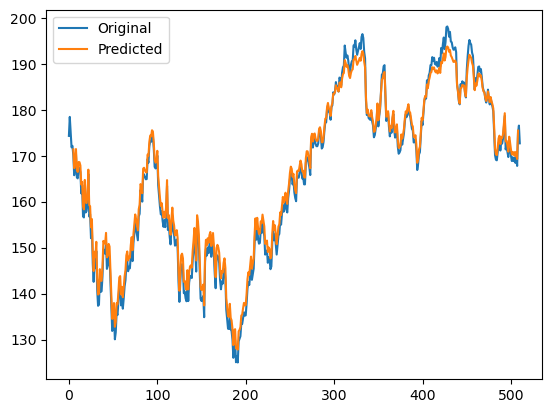

In [12]:
# shift train predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[look_back-1:len(testPredict)+look_back-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='Original')
plt.plot(testPredictPlot, label='Predicted')
plt.legend()
plt.show()